<a href="https://colab.research.google.com/github/chitinglow/Debate/blob/main/Debate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Authenticate

In [ ]:
import tweepy as tw
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
consumer_key = 'jYZSNXHSpXOt7vxhzbHL6UyqV'
consumer_secret = '1Yt59eUBVXG0BQ8aZ2bX3yFyNYM4YtzlSOM19Ucm2d2dpZAzoU'
access_token = '958557552438063106-BUmDPJJqrMznjqSFVSobvaaLVYels45'
access_token_secret = 'Vm6D2VvsPqQFJ9JsWUYSezJZjzOtNMsxI3N86G2sbzlTf'

In [ ]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

# Get Tweets

In [ ]:
hashtag = '#presidentialdebate'
query = tw.Cursor(api.search, q = hashtag).items(1000)
tweets = [{'Tweets':tweet.text, 'Timestamp':tweet.created_at} for tweet in query]
print(tweets)

In [ ]:
df = pd.DataFrame.from_dict(tweets)
df.head()

,Tweets,Timestamp
0,RT @Tedashii: Imagine tuning in to the #debate...,2020-10-10 14:56:15
1,Joe Biden is running scared. After being compl...,2020-10-10 14:54:42
2,RT @PaulaReidCBS: Husband: Why can’t the moder...,2020-10-10 14:54:41
3,RT @jaydiggsmusic: Jay Diggs with his new smas...,2020-10-10 14:52:04
4,RT @jaydiggsmusic: Jay Diggs with his new smas...,2020-10-10 14:51:02


In [ ]:
trump_refs = ['DonaldTrump', 'Donald Trump', 'Donald', 'Trump', 'Trump\'s']
biden_refs = ['JoeBiden', 'Joe Biden', 'Joe', 'Biden', 'Biden\'s']

In [ ]:
def identify_subject(tweet, refs):
  flag = 0
  for ref in refs:
    if tweet.find(ref) != -1:
      flag = 1
    return flag

df['Trump'] = df['Tweets'].apply(lambda x: identify_subject(x, trump_refs))
df['Biden'] = df['Tweets'].apply(lambda x: identify_subject(x, biden_refs))

# Preprocess

In [ ]:
import nltk
from nltk.corpus import stopwords
from textblob import Word, TextBlob

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
custom_stopwords = ['RT', '#PresidentialDebate']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def preprocess_tweet(tweet, custom_stopwords):
  preprocessed_tweets = tweet
  preprocessed_tweets.replace('[^\w\s]', '')
  preprocessed_tweets = " ".join(word for word in preprocessed_tweets.split() if word not in stop_words)
  preprocessed_tweets = " ".join(word for word in preprocessed_tweets.split() if word not in custom_stopwords)
  preprocessed_tweets = " ".join(Word(word).lemmatize() for word in preprocessed_tweets.split())
  return(preprocessed_tweets)

df['Processed Tweet'] = df['Tweets'].apply(lambda x: preprocess_tweet(x, custom_stopwords))
df.head()

,Tweets,Timestamp,Trump,Biden,Processed Tweet
0,RT @Tedashii: Imagine tuning in to the #debate...,2020-10-10 14:56:15,0,0,@Tedashii: Imagine tuning #debates learn think...
1,Joe Biden is running scared. After being compl...,2020-10-10 14:54:42,0,0,Joe Biden running scared. After completely out...
2,RT @PaulaReidCBS: Husband: Why can’t the moder...,2020-10-10 14:54:41,0,0,@PaulaReidCBS: Husband: Why can’t moderator cu...
3,RT @jaydiggsmusic: Jay Diggs with his new smas...,2020-10-10 14:52:04,0,0,@jaydiggsmusic: Jay Diggs new smash hit taking...
4,RT @jaydiggsmusic: Jay Diggs with his new smas...,2020-10-10 14:51:02,0,0,@jaydiggsmusic: Jay Diggs new smash hit taking...


# Calculate Sentiment

In [ ]:
df['Polarity'] = df['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[0])
df['subjectivity'] = df['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[1])
df.head()

,Tweets,Timestamp,Trump,Biden,Processed Tweet,Polarity,subjectivity
0,RT @Tedashii: Imagine tuning in to the #debate...,2020-10-10 14:56:15,0,0,@Tedashii: Imagine tuning #debates learn think...,-0.250000,0.900000
1,Joe Biden is running scared. After being compl...,2020-10-10 14:54:42,0,0,Joe Biden running scared. After completely out...,0.175000,0.366667
2,RT @PaulaReidCBS: Husband: Why can’t the moder...,2020-10-10 14:54:41,0,0,@PaulaReidCBS: Husband: Why can’t moderator cu...,0.000000,0.000000
3,RT @jaydiggsmusic: Jay Diggs with his new smas...,2020-10-10 14:52:04,0,0,@jaydiggsmusic: Jay Diggs new smash hit taking...,0.468182,0.677273
4,RT @jaydiggsmusic: Jay Diggs with his new smas...,2020-10-10 14:51:02,0,0,@jaydiggsmusic: Jay Diggs new smash hit taking...,0.468182,0.677273


In [ ]:
display(df[df['Trump']==1][['Trump','Polarity','subjectivity']].groupby('Trump').agg([np.mean, np.max, np.min, np.median]))
df[df['Biden']==1][['Biden','Polarity','subjectivity']].groupby('Biden').agg([np.mean, np.max, np.min, np.median])

Polarity                    subjectivity                      
           mean   amax amin median         mean      amax amin median
Trump                                                                
1      0.022271  0.875 -0.4    0.0     0.098976  0.966667  0.0    0.0

Polarity                       subjectivity                   
           mean      amax amin median         mean   amax amin median
Biden                                                                
1      0.022934  0.542857 -0.4    0.0     0.085128  0.875  0.0    0.0

# Visualize

In [ ]:
biden = df[df['Biden']==1][['Timestamp', 'Polarity']]
biden = biden.sort_values(by='Timestamp', ascending=True)
biden['MA Polarity'] = biden.Polarity.rolling(10, min_periods=3).mean()

trump = df[df['Trump']==1][['Timestamp', 'Polarity']]
trump = trump.sort_values(by='Timestamp', ascending=True)
trump['MA Polarity'] = trump.Polarity.rolling(10, min_periods=3).mean()

In [ ]:
trump.head()

,Timestamp,Polarity,MA Polarity
993,2020-10-09 23:14:02,0.00,NaN
980,2020-10-09 23:19:17,0.35,NaN
977,2020-10-09 23:20:01,0.00,0.116667
966,2020-10-09 23:23:27,-0.40,-0.012500
953,2020-10-09 23:27:19,0.00,-0.010000


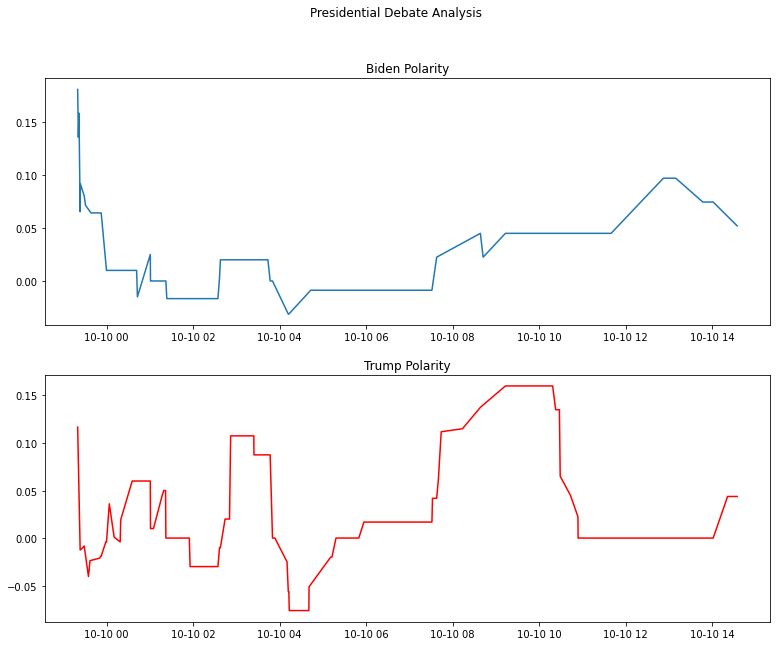

In [ ]:
repub = 'red'
demo = 'blue'
fig, axes = plt.subplots(2, 1, figsize=(13, 10))

axes[0].plot(biden['Timestamp'], biden['MA Polarity'])
axes[0].set_title("\n".join(["Biden Polarity"]))
axes[1].plot(trump['Timestamp'], trump['MA Polarity'], color='red')
axes[1].set_title("\n".join(["Trump Polarity"]))

fig.suptitle("\n".join(["Presidential Debate Analysis"]), y=0.98)

plt.show()